In [1]:
import time
import datetime
import sys; sys.path.insert(0, "..")
from src.models import NeuralNet, BayesianNN, GP, LUNA, NLM
from src.utils import generate_data, neg_log_likelihood, epistemic_uncertainty

In [2]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam
from autograd import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Comparison of Methods

We compare five of the modeling methods referenced in the paper: Bayesian Neural Networks (with HMC sampling), Gaussian Processes (GP), LUNA, Neural Linear Model (NLM), and Ensemble Bootstrapping. 

#### Generate Cubic Gap Data

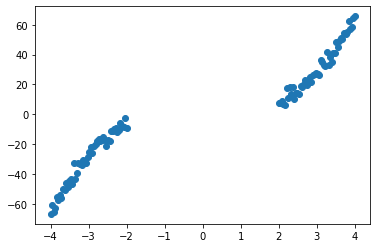

In [3]:
# Generate synthetic data
# np.random.RandomState(207)

# x, y, x_test, y_test = generate_data(number_of_points=50, noise_variance=9)

df = pd.read_csv('data_points.csv', names = ['x', 'y'], header = 0)
df_test = pd.read_csv('data_points_test.csv', names = ['x', 'y'], header = 0)
x = df.x.values.reshape(1, -1)
y = df.y.values.reshape(1, -1)
x_test = df_test.x.values.reshape(1, -1)
y_test = df_test.y.values.reshape(1, -1)

plt.scatter(x, y)
plt.show()

We also divide the test data into gap (data-scare) and non-gap (data-rich) regions in order to calculate the epistemic uncertainty for each.

In [4]:
# Setup gap and non-gap indices
gap_idx = np.logical_and(x_test > -2, x_test < 2)
x_test_gap = x_test[gap_idx].reshape(1,-1)
y_test_gap = y_test[gap_idx].reshape(1,-1)

non_gap_idx = np.logical_or(np.logical_and(x_test > -4, x_test < -2),np.logical_and(x_test > 2, x_test < 4))
x_test_non_gap = x_test[non_gap_idx].reshape(1,-1)
y_test_non_gap = y_test[non_gap_idx].reshape(1,-1)

#### Bayesian Neural Network

In [5]:
# Architecture
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

width = [50] # Use single layer to save computation time (same as the paper)
hidden_layers = len(width)
input_dim = 1
output_dim = 1

architecture = {
    'width': width,
    'hidden_layers': hidden_layers,
    'input_dim': input_dim,
    'output_dim': output_dim,
    'activation_fn_type': 'relu',
    'activation_fn_params': 'rate=1',
    'activation_fn': activation_fn,
}

params = {
    'step_size': 5e-2,
    'max_iteration': 10000,
    'random_restarts': 1,
    'reg_param':1e-5
}


random = np.random.RandomState(207) #set random state to make the experiments replicable

# Initialize a Bayesian neural network
bnn = BayesianNN(architecture, random=random)

#fit Bayesian neural network to obtain MLE/MAP solution for weights
t0 = time.time()
bnn.fit(x, y, params)
tbnn_fit = round((time.time()-t0), 0)
tbnn_fit_str = str(datetime.timedelta(seconds = tbnn_fit))

print("")
print("Training took {} (h:mm:ss)".format(tbnn_fit_str))

Iteration 0 loss 2486.00064292431; gradient mag: 1573.3770958401697
Iteration 100 loss 67.207917676123; gradient mag: 19.044855063772996
Iteration 200 loss 10.614703283210998; gradient mag: 2.5586885199042992
Iteration 300 loss 7.960623840446428; gradient mag: 0.933609140284655
Iteration 400 loss 7.638202971962725; gradient mag: 0.6946658656260304
Iteration 500 loss 7.544797414041847; gradient mag: 2.0791457919927256
Iteration 600 loss 7.461194181919421; gradient mag: 1.8066587899168627
Iteration 700 loss 7.433606509482854; gradient mag: 0.46278216646155923
Iteration 800 loss 7.426693556551346; gradient mag: 0.4594553296470305
Iteration 900 loss 7.381706657901253; gradient mag: 1.8664510703470027
Iteration 1000 loss 7.367944763893151; gradient mag: 2.4266456862454606
Iteration 1100 loss 7.3632433655746405; gradient mag: 0.45744144429127964
Iteration 1200 loss 7.367044677776937; gradient mag: 3.7185872344269324
Iteration 1300 loss 7.3651659165630115; gradient mag: 3.858725881459001
Iter

In [6]:
# HMC Sampling for Posterior 
HMC_param = {'step_size': 5e-3, 
             'leapfrog_steps': 60, 
             'total_samples': 5000, 
             'burn_in': 0.1, 
             'thinning_factor': 2}

noise_sd = 3.
prior_sd = 5.

t0 = time.time()
bnn.sample_HMC(x, y, prior_sd = prior_sd, noise_sd = noise_sd, HMC_param = HMC_param)
tbnn_hmc = round((time.time()-t0), 0)
tbnn_hmc_str = str(datetime.timedelta(seconds = tbnn_hmc))

print('Final accept =', bnn.accept)
print("")
print("Sampling took {} (h:mm:ss)".format(tbnn_hmc_str))
tbnn = tbnn_fit + tbnn_hmc
tbnn_str = str(datetime.timedelta(seconds = tbnn))
print("Total training and sampling took {} (h:mm:ss)".format(tbnn_str))

bnn_pp = bnn.get_posterior_predictive(x_test, add_noise = True)

Iteration 0, accept = 0.0


/media/pau/35c2971c-82d3-474b-82eb-2786b209a05c/anaconda3/envs/am207/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Iteration 100, accept = 0.93999999999906
Iteration 200, accept = 0.8849999999995576
Iteration 300, accept = 0.8999999999997
Iteration 400, accept = 0.9124999999997719
Iteration 500, accept = 0.8939999999998213
Iteration 600, accept = 0.8949999999998508
Iteration 700, accept = 0.891428571428444
Iteration 800, accept = 0.8862499999998892
Iteration 900, accept = 0.8788888888887912
Iteration 1000, accept = 0.8739999999999125
Iteration 1100, accept = 0.859090909090831
Iteration 1200, accept = 0.8541666666665955
Iteration 1300, accept = 0.8507692307691653
Iteration 1400, accept = 0.8464285714285109
Iteration 1500, accept = 0.8446666666666103
Iteration 1600, accept = 0.8399999999999475
Iteration 1700, accept = 0.8399999999999506
Iteration 1800, accept = 0.8444444444443975
Iteration 1900, accept = 0.8473684210525869
Iteration 2000, accept = 0.8514999999999574
Iteration 2100, accept = 0.8538095238094832
Iteration 2200, accept = 0.8531818181817794
Iteration 2300, accept = 0.849999999999963
Itera

In [7]:
bnn_dict = {}

bnn_dict['time'] = tbnn

# Calculate percentiles
bnn_dict['pp_upper'] = np.percentile(bnn_pp, 97.5, axis=0)
bnn_dict['pp_lower'] = np.percentile(bnn_pp, 2.5, axis=0)
bnn_dict['pp_upper2'] = np.percentile(bnn_pp, 84, axis=0)
bnn_dict['pp_lower2'] = np.percentile(bnn_pp, 16, axis=0)
bnn_dict['pp_upper3'] = np.percentile(bnn_pp, 99.85, axis=0)
bnn_dict['pp_lower3'] = np.percentile(bnn_pp, 0.15, axis=0)
bnn_dict['pp_mean'] = np.mean(bnn_pp, axis=0)

# Calculate log-likelihood
posterior_predictive_train = bnn.get_posterior_predictive(x, add_noise = True)
bnn_dict['ll_train'] = neg_log_likelihood(posterior_predictive_train, y, noise_sd**2) * -1

posterior_predictive_non_gap_noise = bnn.get_posterior_predictive(x_test_non_gap, add_noise = True)
bnn_dict['ll_test'] = neg_log_likelihood(posterior_predictive_non_gap_noise, y_test_non_gap, noise_sd**2) * -1

# Calculate epistemic uncertainty
posterior_predictive_gap = bnn.get_posterior_predictive(x_test_gap, add_noise = False)
posterior_predictive_non_gap = bnn.get_posterior_predictive(x_test_non_gap, add_noise = False)

bnn_dict['eu_gap'] = epistemic_uncertainty(posterior_predictive_gap)
bnn_dict['eu_non_gap'] = epistemic_uncertainty(posterior_predictive_non_gap)

In [8]:
# Save as DataFrame and to CSV
bnn_df = pd.DataFrame(bnn_dict)
bnn_df.to_csv('bnn.csv', index = False)

#### Gaussian Process

In [16]:
# Setup
noise_var = 9
noise_sd = 3.
amplitude = 1
length_scale = 1
length_scale_bounds = 'fixed'
noise_level_bounds = 'fixed'

gp = GP(amplitude, length_scale, length_scale_bounds, noise_var, noise_level_bounds)

In [17]:
# Fit
t0 = time.time()
gp.fit(x, y.flatten())
tgp = round((time.time()-t0), 0)
tgp_str = str(datetime.timedelta(seconds = tgp))
print("Fitting took {} (h:mm:ss)".format(tgp_str))

Fitting took 0:00:00 (h:mm:ss)


In [27]:
gp_dict = {}

gp_dict['time'] = tgp

# Calculate test predictions and standard deviation
gp_dict['y_pred_mean'], gp_dict['y_pred_std'] = gp.predict(x_test)

# Calculate log-likelihood
posterior_predictive_train  = gp.get_posterior_preds(x, n_samples = 5000)
gp_dict['ll_train'] = neg_log_likelihood(posterior_predictive_train.T, y, noise_sd**2) * -1

posterior_predictive_non_gap = gp.get_posterior_preds(x_test_non_gap, n_samples = 5000)
gp_dict['ll_test'] = neg_log_likelihood(posterior_predictive_non_gap.T, y_test_non_gap, noise_sd**2) * -1

# Calculate epistemic uncertainty
posterior_predictive_gap = gp.get_posterior_preds(x_test_gap, n_samples = 5000)

gp_dict['eu_gap'] = epistemic_uncertainty(posterior_predictive_gap.T)
gp_dict['eu_non_gap'] = epistemic_uncertainty(posterior_predictive_non_gap.T)

In [29]:
# Convert to DataFrame
gp_df = pd.DataFrame(gp_dict)
gp_df.to_csv('gp.csv', index = False)

#### LUNA

In [5]:
prior_var = 9
noise_var = 9

In [7]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

width = [50,50] # using the architecture used in the paper
hidden_layers = len(width)
input_dim = 1
output_dim = 1
n_aux = 50

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn,
               'auxiliary_functions': n_aux}

#set random state to make the experiments replicable
rand_state = 207
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
luna = LUNA(architecture, random=random)
print('Number of parameters =', luna.D)
print("")

### define design choices in gradient descent
params = {
    'step_size':1e-2,
    'max_iteration':10000,
    'random_restarts':1,
    'reg_param':100.,
    'lambda_in':100.,
}

t0 = time.time()
luna.fit(x.reshape((1, -1)), y.reshape((1, -1)), params)
tluna_fit = round((time.time()-t0), 0)
tluna_fit_str = str(datetime.timedelta(seconds = tluna_fit))

print("")
print("Training took {} (h:mm:ss)".format(tluna_fit_str))

Number of parameters = 5200

Iteration 0 loss 10715.444128846555; gradient mag: 5360.526171281468
Iteration 100 loss 288.10050386307796; gradient mag: 66.50148495196397
Iteration 200 loss 248.79085353046864; gradient mag: 63.516611689789286
Iteration 300 loss 207.8494518665672; gradient mag: 40.62445384598176
Iteration 400 loss 200.08381457713713; gradient mag: 104.42032598053852
Iteration 500 loss 196.2439062019854; gradient mag: 36.524596903191885
Iteration 600 loss 191.6044791713729; gradient mag: 39.256701161495926
Iteration 700 loss 188.16749201204362; gradient mag: 33.79622052567019
Iteration 800 loss 184.7344458230106; gradient mag: 17.26832514402752
Iteration 900 loss 181.7046343843346; gradient mag: 39.3156524980061
Iteration 1000 loss 179.61889489672822; gradient mag: 84.8253703684144
Iteration 1100 loss 175.34203577812013; gradient mag: 41.558703565110875
Iteration 1200 loss 171.6884376861947; gradient mag: 35.23576304995796
Iteration 1300 loss 168.50070818016607; gradient m

In [8]:
luna_dict = {}

luna_dict['time'] = tluna_fit

y_posterior = luna.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)

luna_dict['pp_upper'] = np.percentile(y_posterior, 97.5, axis=0)
luna_dict['pp_lower'] = np.percentile(y_posterior, 2.5, axis=0)
luna_dict['pp_upper2'] = np.percentile(y_posterior, 84, axis=0)
luna_dict['pp_lower2'] = np.percentile(y_posterior, 16, axis=0)
luna_dict['pp_upper3'] = np.percentile(y_posterior, 99.85, axis=0)
luna_dict['pp_lower3'] = np.percentile(y_posterior, 0.15, axis=0)
luna_dict['pp_mean'] = np.mean(y_posterior, axis=0)

y_posterior_train = luna.get_posterior_preds(x, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
y_posterior_train = y_posterior_train + np.random.normal(0, noise_var**0.5, size=y_posterior_train.shape)

y_posterior_gap = luna.get_posterior_preds(x_test_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
y_posterior_gap = y_posterior_gap + np.random.normal(0, noise_var**0.5, size=y_posterior_gap.shape)

y_posterior_non_gap = luna.get_posterior_preds(x_test_non_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
y_posterior_non_gap = y_posterior_non_gap + np.random.normal(0, noise_var**0.5, size=y_posterior_non_gap.shape)

luna_dict['ll_train'] = neg_log_likelihood(y_posterior_train, y, noise_var) * -1
luna_dict['ll_test'] = neg_log_likelihood(y_posterior_non_gap, y_test_non_gap, noise_var) * -1

luna_dict['eu_gap'] = epistemic_uncertainty(y_posterior_gap)
luna_dict['eu_non_gap'] =  epistemic_uncertainty(y_posterior_non_gap)

# Convert to DataFrame
luna_df = pd.DataFrame(luna_dict)
luna_df.to_csv('luna.csv', index = False)

#### NLM

In [7]:
# Use the same architecture as LUNA
architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 207
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nlm = NLM(architecture, random=random)
print('Number of parameters =', nlm.D)
print("")

### define design choices in gradient descent
params = {
    'step_size':1e-2,
    'max_iteration':10000,
    'random_restarts':1,
    'reg_param':100.,
}

t0 = time.time()
nlm.fit(x.reshape((1, -1)), y.reshape((1, -1)), params)
tnlm_fit = round((time.time()-t0), 0)
tnlm_fit_str = str(datetime.timedelta(seconds = tnlm_fit))

print("")
print("Training took {} (h:mm:ss)".format(tnlm_fit_str))

Number of parameters = 2701

Iteration 0 loss 8676.648065243075; gradient mag: 19648.041945319706
Iteration 100 loss 148.04415871676946; gradient mag: 106.35086513781565
Iteration 200 loss 69.11875841066241; gradient mag: 15.017362631322127
Iteration 300 loss 63.24885020968862; gradient mag: 43.630064593076845
Iteration 400 loss 60.189208164528814; gradient mag: 11.458068313771783
Iteration 500 loss 57.935288514168604; gradient mag: 47.5148763552139
Iteration 600 loss 55.88390919434359; gradient mag: 11.094732186421853
Iteration 700 loss 54.07208810434544; gradient mag: 10.871380248544568
Iteration 800 loss 52.36917909458992; gradient mag: 33.74228398896744
Iteration 900 loss 50.74326399938665; gradient mag: 17.1915755554548
Iteration 1000 loss 49.26269926930047; gradient mag: 34.119339459197846
Iteration 1100 loss 47.80675557216984; gradient mag: 25.171772952349965
Iteration 1200 loss 46.45080134374434; gradient mag: 36.71254710930222
Iteration 1300 loss 45.10550199275454; gradient ma

In [9]:
nlm_dict = {}

nlm_dict['time'] = tnlm_fit

y_posterior = nlm.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)

nlm_dict['pp_upper'] = np.percentile(y_posterior, 97.5, axis=0)
nlm_dict['pp_lower'] = np.percentile(y_posterior, 2.5, axis=0)
nlm_dict['pp_upper2'] = np.percentile(y_posterior, 84, axis=0)
nlm_dict['pp_lower2'] = np.percentile(y_posterior, 16, axis=0)
nlm_dict['pp_upper3'] = np.percentile(y_posterior, 99.85, axis=0)
nlm_dict['pp_lower3'] = np.percentile(y_posterior, 0.15, axis=0)
nlm_dict['pp_mean'] = np.mean(y_posterior, axis=0)

y_posterior_train = nlm.get_posterior_preds(x, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
y_posterior_train = y_posterior_train + np.random.normal(0, noise_var**0.5, size=y_posterior_train.shape)

y_posterior_gap = nlm.get_posterior_preds(x_test_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
y_posterior_gap = y_posterior_gap + np.random.normal(0, noise_var**0.5, size=y_posterior_gap.shape)

y_posterior_non_gap = nlm.get_posterior_preds(x_test_non_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
y_posterior_non_gap = y_posterior_non_gap + np.random.normal(0, noise_var**0.5, size=y_posterior_non_gap.shape)

nlm_dict['ll_train'] = neg_log_likelihood(y_posterior_train, y, noise_var) * -1
nlm_dict['ll_test'] = neg_log_likelihood(y_posterior_non_gap, y_test_non_gap, noise_var) * -1

nlm_dict['eu_gap'] = epistemic_uncertainty(y_posterior_gap)
nlm_dict['eu_non_gap'] =  epistemic_uncertainty(y_posterior_non_gap)

# Convert to DataFrame
nlm_df = pd.DataFrame(nlm_dict)
nlm_df.to_csv('nlm.csv', index = False)

#### MAP

In [10]:
map_nn = nlm.forward(nlm.weights, x_test) + np.random.normal(0, noise_var**0.5, size=x_test.shape)
map_nn_train = nlm.forward(nlm.weights, x) + np.random.normal(0, noise_var**0.5, size=x.shape)

map_nn_gap = nlm.forward(nlm.weights, x_test_gap) + np.random.normal(0, noise_var**0.5, size=x_test_gap.shape)
map_nn_non_gap = nlm.forward(nlm.weights, x_test_non_gap) + np.random.normal(0, noise_var**0.5, size=x_test_non_gap.shape)

map_ll_train = neg_log_likelihood(map_nn_train[0], y, noise_var) * -1
map_ll_test = neg_log_likelihood(map_nn_non_gap[0], y_test_non_gap, noise_var) * -1

map_eu_gap = epistemic_uncertainty(map_nn_gap)
map_eu_non_gap =  epistemic_uncertainty(map_nn_non_gap)

#### Ensemble Bootstraping

In [7]:
params = {
    'step_size':1e-2,
    'max_iteration':2000,
    'random_restarts':1,
    'reg_param':100.,
}

def fit_nn(architecture, random, x, y, params):
    nn = NeuralNet(architecture, random=random)
    nn.fit(x.reshape((1, -1)), y.reshape((1, -1)), params)
    return nn

# Train neural networks with bootstraps of the training data
np.random.seed(207) # For reproducibility
nn_list = []
n_models = 50

t0 = time.time()
for i in range(n_models):
    print("\n======== Model {:} / {:} ========\n".format(i+1, n_models))
    x, y, _, _ = generate_data(number_of_points=50, noise_variance=9)
    rand_state = np.random.randint(0, 100000)
    random = np.random.RandomState(rand_state)
    nn = fit_nn(architecture, random, x, y, params)
    nn_list.append(nn)
    
tens_fit = round((time.time()-t0), 0)
tens_fit_str = str(datetime.timedelta(seconds = tens_fit))

print("")
print("Training took {} (h:mm:ss)".format(tens_fit_str))


======== Model 1 / 50 ========

Iteration 0 loss 11731.477344392748; gradient mag: 22673.059166902898
Iteration 100 loss 76.09682169101382; gradient mag: 15.175725787030416
Iteration 200 loss 64.57966244564234; gradient mag: 14.015611449661874
Iteration 300 loss 59.49410344855297; gradient mag: 15.653574395833475
Iteration 400 loss 55.94795540225475; gradient mag: 32.106486655021044
Iteration 500 loss 53.10656378592759; gradient mag: 10.149738939693576
Iteration 600 loss 50.70454417540846; gradient mag: 6.636825923882991
Iteration 700 loss 48.576369266936574; gradient mag: 9.770286007919623
Iteration 800 loss 46.717603256596874; gradient mag: 24.529166672672254
Iteration 900 loss 44.967075400056494; gradient mag: 2.7138766148737004
Iteration 1000 loss 43.38163307822824; gradient mag: 4.603907103540486
Iteration 1100 loss 41.934751841205724; gradient mag: 5.519709314342508
Iteration 1200 loss 40.603674833542854; gradient mag: 4.551459557654537
Iteration 1300 loss 39.36171048003362; gra

Iteration 1300 loss 42.22481363894076; gradient mag: 6.510011780034192
Iteration 1400 loss 41.138190646677494; gradient mag: 28.79873798627186
Iteration 1500 loss 40.01942678502037; gradient mag: 9.991834522449
Iteration 1600 loss 39.06089277849426; gradient mag: 48.976122656868384
Iteration 1700 loss 37.97661153045656; gradient mag: 22.53698946107955
Iteration 1800 loss 36.973436946481; gradient mag: 12.209146610944778
Iteration 1900 loss 36.03158085012215; gradient mag: 27.64113722687436

======== Model 7 / 50 ========

Iteration 0 loss 2612.8327500008036; gradient mag: 6543.261359718476
Iteration 100 loss 86.36654171994809; gradient mag: 17.705687476613605
Iteration 200 loss 71.62656315228789; gradient mag: 9.529071944774163
Iteration 300 loss 65.62333405211373; gradient mag: 9.521972865100192
Iteration 400 loss 61.135104667926; gradient mag: 13.65414966384863
Iteration 500 loss 57.299887784861355; gradient mag: 6.922841901766744
Iteration 600 loss 53.887318068530206; gradient mag: 

Iteration 600 loss 60.4243349719942; gradient mag: 17.913982664926543
Iteration 700 loss 59.28819700752032; gradient mag: 22.146958993109696
Iteration 800 loss 58.17595199425678; gradient mag: 5.73583025333296
Iteration 900 loss 57.121701012860264; gradient mag: 20.469484575686607
Iteration 1000 loss 56.46613137166225; gradient mag: 133.0003868643042
Iteration 1100 loss 54.95063854116125; gradient mag: 8.023304022249386
Iteration 1200 loss 53.94954217537654; gradient mag: 5.290038225366129
Iteration 1300 loss 52.97723164085651; gradient mag: 28.792098013384454
Iteration 1400 loss 51.98992921692008; gradient mag: 7.550844853513405
Iteration 1500 loss 51.033554110047625; gradient mag: 9.634794767557237
Iteration 1600 loss 50.094136578602615; gradient mag: 13.74829952394608
Iteration 1700 loss 49.176219651692215; gradient mag: 18.295696942687147
Iteration 1800 loss 48.23593245367159; gradient mag: 7.37329598817931
Iteration 1900 loss 47.21990627915743; gradient mag: 8.11643839703532

====


======== Model 18 / 50 ========

Iteration 0 loss 8424.411740478929; gradient mag: 20212.113822773033
Iteration 100 loss 104.23705738318469; gradient mag: 54.75235805458286
Iteration 200 loss 65.2429505644168; gradient mag: 14.30050536270216
Iteration 300 loss 58.25927695983704; gradient mag: 5.0197876415627265
Iteration 400 loss 55.5929982263933; gradient mag: 9.187266370804164
Iteration 500 loss 53.44552391125167; gradient mag: 12.532004869377964
Iteration 600 loss 51.585476790501964; gradient mag: 12.746839756786786
Iteration 700 loss 49.91966353132299; gradient mag: 10.04816087167612
Iteration 800 loss 48.370127557950894; gradient mag: 5.868869468807398
Iteration 900 loss 46.92114145538951; gradient mag: 5.522951030575312
Iteration 1000 loss 45.56475667451006; gradient mag: 11.16489379883071
Iteration 1100 loss 44.317884441147946; gradient mag: 26.489894232280907
Iteration 1200 loss 43.057485146122694; gradient mag: 5.327612804159514
Iteration 1300 loss 41.894139749068955; gradien

Iteration 1300 loss 34.192886234561975; gradient mag: 2.275624048622507
Iteration 1400 loss 33.147874163140216; gradient mag: 4.429939090748945
Iteration 1500 loss 32.15611108975298; gradient mag: 2.9019335285146024
Iteration 1600 loss 31.219732168832316; gradient mag: 7.459549700317244
Iteration 1700 loss 30.33751177625148; gradient mag: 18.567784722534544
Iteration 1800 loss 29.472080879840792; gradient mag: 9.064121774768365
Iteration 1900 loss 28.65199152808555; gradient mag: 14.93817819422133

======== Model 24 / 50 ========

Iteration 0 loss 22984.26336066223; gradient mag: 35774.433723797956
Iteration 100 loss 145.2943027418905; gradient mag: 128.30307783485057
Iteration 200 loss 86.53918922705262; gradient mag: 31.682271098254272
Iteration 300 loss 79.07302666659943; gradient mag: 13.623259240379829
Iteration 400 loss 74.24390418260376; gradient mag: 12.92485394917767
Iteration 500 loss 72.17348329266136; gradient mag: 8.291103630042937
Iteration 600 loss 70.39408169229948; gra

Iteration 600 loss 38.62990074429295; gradient mag: 16.01921707667641
Iteration 700 loss 36.89129630962385; gradient mag: 29.329656018767775
Iteration 800 loss 35.21498598431387; gradient mag: 5.2852130243648805
Iteration 900 loss 33.718820690495214; gradient mag: 13.37618355137794
Iteration 1000 loss 32.302107805731076; gradient mag: 3.756751648556617
Iteration 1100 loss 30.99337896605605; gradient mag: 3.8211630751341765
Iteration 1200 loss 29.769202654724506; gradient mag: 10.51618738574486
Iteration 1300 loss 28.621764143358668; gradient mag: 7.5948158035669175
Iteration 1400 loss 27.541313533880846; gradient mag: 4.316315419714882
Iteration 1500 loss 26.515584476509037; gradient mag: 4.066658731055941
Iteration 1600 loss 25.53908327333354; gradient mag: 7.854941365936421
Iteration 1700 loss 24.63948950527426; gradient mag: 3.6745597144480384
Iteration 1800 loss 23.79209597088142; gradient mag: 10.28909549595753
Iteration 1900 loss 22.995663634537507; gradient mag: 4.64870642233074

Iteration 1900 loss 28.959917605849597; gradient mag: 24.64092034497868

======== Model 35 / 50 ========

Iteration 0 loss 978.0913643995028; gradient mag: 6425.91046170494
Iteration 100 loss 77.76040139044086; gradient mag: 22.420977456726593
Iteration 200 loss 63.868101607996536; gradient mag: 16.111234581525196
Iteration 300 loss 58.48480857518335; gradient mag: 20.802306482199487
Iteration 400 loss 54.93602198695744; gradient mag: 21.715664137711578
Iteration 500 loss 51.84302582622525; gradient mag: 21.433578338928925
Iteration 600 loss 49.0609805792557; gradient mag: 8.428435711278222
Iteration 700 loss 46.58347565725276; gradient mag: 8.330938967379172
Iteration 800 loss 44.31600752512118; gradient mag: 23.465194801116578
Iteration 900 loss 42.25801210155145; gradient mag: 19.934582304686582
Iteration 1000 loss 40.34450287636549; gradient mag: 4.180115740756117
Iteration 1100 loss 38.58771955198308; gradient mag: 6.405944570886632
Iteration 1200 loss 36.978362240058594; gradient

Iteration 1200 loss 33.89474957243291; gradient mag: 18.201462879585332
Iteration 1300 loss 32.77789059407134; gradient mag: 12.060709327965064
Iteration 1400 loss 31.7414152748594; gradient mag: 8.198616344390116
Iteration 1500 loss 30.79342157366686; gradient mag: 7.707603299125012
Iteration 1600 loss 29.890731113005124; gradient mag: 13.521757908246457
Iteration 1700 loss 29.07259481625597; gradient mag: 15.591338972138358
Iteration 1800 loss 28.27968085219934; gradient mag: 16.084551270925697
Iteration 1900 loss 27.529223259904633; gradient mag: 10.722927564255338

======== Model 41 / 50 ========

Iteration 0 loss 11428.174242816687; gradient mag: 24579.820374531573
Iteration 100 loss 96.00456461408126; gradient mag: 45.25158092504883
Iteration 200 loss 73.83223465481676; gradient mag: 120.75350526165097
Iteration 300 loss 65.94026476376962; gradient mag: 12.02957250040021
Iteration 400 loss 62.62171571786229; gradient mag: 20.582907412032927
Iteration 500 loss 59.881695581181326; 

Iteration 500 loss 49.89052166282829; gradient mag: 6.0860590967919554
Iteration 600 loss 47.95893335212301; gradient mag: 11.54067056290756
Iteration 700 loss 46.161271088478365; gradient mag: 11.5147205263784
Iteration 800 loss 44.50145177958825; gradient mag: 9.437746383400258
Iteration 900 loss 42.918436544324805; gradient mag: 5.747594786240166
Iteration 1000 loss 41.43880304668142; gradient mag: 11.72945248673072
Iteration 1100 loss 40.05280115744514; gradient mag: 11.341809309149854
Iteration 1200 loss 38.740806917694584; gradient mag: 13.11083973291717
Iteration 1300 loss 37.50722792210182; gradient mag: 5.922868686720085
Iteration 1400 loss 36.327633381307386; gradient mag: 26.14455092136214
Iteration 1500 loss 35.19044736536099; gradient mag: 14.615335269188769
Iteration 1600 loss 34.12497731776825; gradient mag: 29.34323627866592
Iteration 1700 loss 33.11062780587481; gradient mag: 35.24267602943967
Iteration 1800 loss 32.10067091654513; gradient mag: 20.203934768630027
Iter

In [10]:
ens_dict = {}

ens_dict['time'] = tens_fit

# Make predictions with the ensemble
ens_y_pred = [nn.forward(nn.weights, x_test.reshape(1,-1)) for nn in nn_list]
ens_y_pred = np.concatenate([y.reshape(1,-1) for y in ens_y_pred])

# Calculate percentiles
ens_dict['pp_upper'] = np.percentile(ens_y_pred, 97.5, axis=0)
ens_dict['pp_lower'] = np.percentile(ens_y_pred, 2.5, axis=0)
ens_dict['pp_upper2'] = np.percentile(ens_y_pred, 84, axis=0)
ens_dict['pp_lower2'] = np.percentile(ens_y_pred, 16, axis=0)
ens_dict['pp_upper3'] = np.percentile(ens_y_pred, 99.85, axis=0)
ens_dict['pp_lower3'] = np.percentile(ens_y_pred, 0.15, axis=0)
ens_dict['pp_mean'] = np.mean(ens_y_pred, axis=0)

ens_y_pred_train = [nn.forward(nn.weights, x.reshape(1,-1)) for nn in nn_list]
ens_y_pred_train = np.concatenate([y.reshape(1,-1) for y in ens_y_pred_train])
ens_y_pred_train = ens_y_pred_train + np.random.normal(0, noise_var**0.5, size=x.shape)

ens_y_pred_gap = [nn.forward(nn.weights, x_test_gap.reshape(1,-1)) for nn in nn_list]
ens_y_pred_gap = np.concatenate([y.reshape(1,-1) for y in ens_y_pred_gap])
ens_y_pred_gap = ens_y_pred_gap + np.random.normal(0, noise_var**0.5, size=x_test_gap.shape)

ens_y_pred_non_gap = [nn.forward(nn.weights, x_test_non_gap.reshape(1,-1)) for nn in nn_list]
ens_y_pred_non_gap = np.concatenate([y.reshape(1,-1) for y in ens_y_pred_non_gap])
ens_y_pred_non_gap = ens_y_pred_non_gap + np.random.normal(0, noise_var**0.5, size=x_test_non_gap.shape)

ens_dict['ll_train'] = neg_log_likelihood(ens_y_pred_train, y, noise_var) * -1
ens_dict['ll_test'] = neg_log_likelihood(ens_y_pred_non_gap, y_test_non_gap, noise_var) * -1

ens_dict['eu_gap'] = epistemic_uncertainty(ens_y_pred_gap)
ens_dict['eu_non_gap'] =  epistemic_uncertainty(ens_y_pred_non_gap)

# Convert to DataFrame
ens_df = pd.DataFrame(ens_dict)
ens_df.to_csv('ens.csv', index = False)

#### Final Graph

In [11]:
# Read in csvs if you had to restart the kernel
bnn_df = pd.read_csv('bnn.csv')
gp_df = pd.read_csv('gp.csv')
luna_df = pd.read_csv('luna.csv')
nlm_df = pd.read_csv('nlm.csv')
ens_df = pd.read_csv('ens.csv')

In [12]:
dfs = [bnn_df, gp_df, luna_df, nlm_df, ens_df]
titles = ['BNN (HMC)', 'GP', 'LUNA', 'NLM', 'MAP', 'ENS. BOOST']

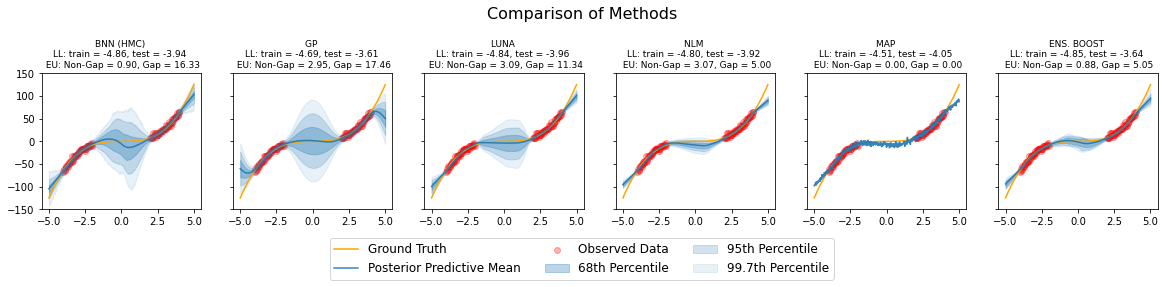

In [13]:
fig, axs = plt.subplots(1, 6, figsize = (20, 2.5), sharex = True, sharey = True)

for i, ax in enumerate(axs.ravel()):
    if i < 5:
        df = dfs[i]
    else:
        df = dfs[i-1]
    
    ax.scatter(x[0,:], y[0,:], color='red', alpha=0.3, label='Observed Data')
    ax.plot(x_test[0,:], y_test[0,:], color='orange', label="Ground Truth")
    
    if i == 1:
        ax.plot(x_test[0,:], df['y_pred_mean'], color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
        ax.fill_between(x_test[0,:], df['y_pred_mean'] - df['y_pred_std'], df['y_pred_mean'] + df['y_pred_std'], color = 'tab:blue', alpha = 0.3, label="68th Percentile")
        ax.fill_between(x_test[0,:], df['y_pred_mean'] - 2 * df['y_pred_std'], df['y_pred_mean'] + 2 * df['y_pred_std'], color='tab:blue', alpha=0.2, label="95th Percentile")
        ax.fill_between(x_test[0,:], df['y_pred_mean'] - 3 * df['y_pred_std'], df['y_pred_mean'] + 3 * df['y_pred_std'], color = 'tab:blue', alpha = 0.1, label="99.7th Percentile")
        ax.set_title("{} \nLL: train = {:.2f}, test = {:.2f} \n EU: Non-Gap = {:.2f}, Gap = {:.2f}".format(titles[i], df['ll_train'][0], df['ll_test'][0], df['eu_non_gap'][0], df['eu_gap'][0]), fontsize = 9)
    elif i == 4:
        ax.plot(x_test[0,:], map_nn[0, 0, :], color='tab:blue', alpha=0.9, label='MAP')
        ax.set_title("{} \nLL: train = {:.2f}, test = {:.2f} \n EU: Non-Gap = {:.2f}, Gap = {:.2f}".format(titles[i], map_ll_train, map_ll_test, map_eu_non_gap, map_eu_gap), fontsize = 9)
    else:
        ax.plot(x_test[0,:], df['pp_mean'], color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
        ax.fill_between(x_test[0,:], df['pp_upper2'], df['pp_lower2'], color = 'tab:blue', alpha = 0.3, label="68th Percentile")
        ax.fill_between(x_test[0,:], df['pp_upper'], df['pp_lower'], color='tab:blue', alpha=0.2, label="95th Percentile")
        ax.fill_between(x_test[0,:], df['pp_upper3'], df['pp_lower3'], color = 'tab:blue', alpha = 0.1, label="99.7th Percentile")
        ax.set_title("{} \nLL: train = {:.2f}, test = {:.2f} \n EU: Non-Gap = {:.2f}, Gap = {:.2f}".format(titles[i], df['ll_train'][0], df['ll_test'][0], df['eu_non_gap'][0], df['eu_gap'][0]), fontsize = 9)

    ax.set_ylim([-150, 150])   
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor = (0.5, -0.3), fontsize = 12)

plt.suptitle("Comparison of Methods", y = 1.25, fontsize = 16)
plt.show()

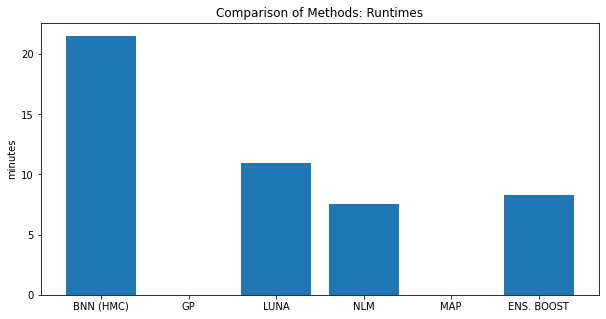

In [20]:
runtimes = np.array([bnn_df['time'][0], gp_df['time'][0], luna_df['time'][0], nlm_df['time'][0], 0, ens_df['time'][0]])

plt.figure(figsize = (10, 5))
plt.bar(titles, (runtimes/60))
plt.ylabel('minutes')

plt.title('Comparison of Methods: Runtimes')
plt.show()